<a href="https://colab.research.google.com/github/athabrani/DeepLearning/blob/main/DeepRNN_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, LSTM, GRU, Dense, Dropout, MaxPooling1D, Conv1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from keras_tuner import Hyperband
import keras_tuner as kt
import os
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import requests


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

#Deteksi Sarkasme

In [ ]:
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json'
response = requests.get(url)


In [ ]:
# Cek apakah request berhasil
if response.status_code == 200:
    data = response.text
else:
    print(f"Terjadi kesalahan dalam pengambilan data: {response.status_code}")
    data = ""

# Tampilkan cuplikan dari data JSON yang tidak terformat
print("Cuplikan data JSON yang tidak terformat:")
print(data[:500])  # Menampilkan 500 karakter pertama untuk cuplikan

# Memperbaiki JSON yang tidak terformat
# Karena format JSON adalah JSON Lines (setiap objek di baris baru), kita bisa menggunakannya langsung
try:
    # Menggunakan jsonlines untuk parsing
    json_data = [json.loads(line) for line in data.splitlines()]
    print("\nData JSON berhasil diformat.")
except json.JSONDecodeError as e:
    print(f"Terjadi kesalahan saat memformat JSON: {e}")

# Inisialisasi DataFrame dari data JSON
df = pd.DataFrame(json_data)

# Memeriksa distribusi kelas
print("Class distribution:")
print(df['is_sarcastic'].value_counts())
print("\nPercentage:")
print(df['is_sarcastic'].value_counts(normalize=True) * 100)

# Fungsi Text preprocessing
def preprocess_text(text):
    # Membuat teks menjadi huruf kecil
    text = text.lower()

    # Pertahankan tanda baca yang berpotensi penting untuk sarkasme
    text = re.sub(r'[^\w\s\'\"!?.,]', '', text)

    # Tokenisasi
    tokens = word_tokenize(text)

    # Filter stopwords secara selektif (pertahankan kata-kata penting)
    custom_stopwords = set(stopwords.words('english')) - {'not', 'no', 'very', 'too', 'only', 'just'}
    tokens = [word for word in tokens if word not in custom_stopwords]

    return ' '.join(tokens)

# Menerapkan preprocessing ke headlines
df['processed_headline'] = df['headline'].apply(preprocess_text)
print("\nProcessed headlines:")
print(df['processed_headline'].head())

# Mengambil kata tambahan dari link artikel
df['additional_words'] = df['article_link'].apply(
    lambda x: re.findall(r'\w+', x.split('/')[-1]) if '/' in x else []
).apply(lambda x: [word for word in x if word not in ['html', 'htm'] and len(word) > 1])
df['additional_words'] = df['additional_words'].apply(
    lambda x: x[:-1] + x[-1].split('_')[:-1] if x and len(x[-1].split('_')) > 1 else x
)
df['additional_words'] = df['additional_words'].apply(
    lambda x: x[:-1] if x and len(x[-1]) < 3 else x
)
print(df['additional_words'])

# Menggabungkan headline dan kata tambahan
df['processed_headline'] = ' ' + df['additional_words'].apply(' '.join) + ' ' + df['processed_headline']
print("\nCombined processed headlines:")
print(df['processed_headline'].head())

Cuplikan data JSON yang tidak terformat:
{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret 'black code' for minority shoppers", "is_sarcastic": 0}
{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "is_sarcastic": 0}
{"article_link": "https://local.theonion.com/mom-star

Data JSON berhasil diformat.
Class distribution:
is_sarcastic
0    14985
1    11724
Name: count, dtype: int64

Percentage:
is_sarcastic
0    56.104684
1    43.895316
Name: proportion, dtype: float64

Processed headlines:
0    former versace store clerk sues secret 'black ...
1    'roseanne ' revival catches thorny political m...
2    mom starting fear son 's web series closest th...
3    boehner just wants wife listen , not come alte...
4    j.k. rowling 

In [ ]:
sentences = [item['headline'] for item in json_data]  # Gunakan json_data yang sudah diformat
labels = [item['is_sarcastic'] for item in json_data]  # Gunakan json_data yang sudah diformat

# Tokenisasi dan padding
vocab_size = 10000
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post', maxlen=100)

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

print("\nTraining data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (21367, 100)
Testing data shape: (5342, 100)


In [ ]:
def build_model(hp):
    model = tf.keras.Sequential()

    # Embedding layer
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=hp.Int('embed_dim', 32, 128, step=32)
    ))

    # First RNN layer (return_sequences=True untuk menyambung ke RNN berikutnya)
    model.add(tf.keras.layers.SimpleRNN(
        units=hp.Int('rnn_units_1', 32, 128, step=32),
        dropout=hp.Choice('dropout_rate_1', [0.2, 0.3, 0.5]),
        return_sequences=True
    ))

    # Second RNN layer (return_sequences=True)
    model.add(tf.keras.layers.SimpleRNN(
        units=hp.Int('rnn_units_2', 32, 128, step=32),
        dropout=hp.Choice('dropout_rate_2', [0.2, 0.3, 0.5]),
        return_sequences=True
    ))

    # Third RNN layer (last one, return_sequences=False)
    model.add(tf.keras.layers.SimpleRNN(
        units=hp.Int('rnn_units_3', 32, 128, step=32),
        dropout=hp.Choice('dropout_rate_3', [0.2, 0.3, 0.5]),
        return_sequences=False
    ))

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(hp.Choice('lr', [1e-3, 1e-4])),
        metrics=['accuracy']
    )

    return model


# Tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='sarcasm_rnn_tuner',
    project_name='simple_rnn_tuning'
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
tuner.search(X_train, np.array(y_train), epochs=10, validation_split=0.2, callbacks=[early_stopping])
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 04m 57s]
val_accuracy: 0.5552175939083099

Best val_accuracy So Far: 0.8511932790279388
Total elapsed time: 00h 49m 15s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
history = best_model.fit(
    X_train,
    np.array(y_train),
    epochs=10,
    callbacks=[early_stopping],
    validation_data=(X_test, np.array(y_test)))

Epoch 1/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.9169 - loss: 0.2157 - val_accuracy: 0.8532 - val_loss: 0.3970
Epoch 2/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.9350 - loss: 0.1760 - val_accuracy: 0.8628 - val_loss: 0.3776
Epoch 3/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.9466 - loss: 0.1468 - val_accuracy: 0.8618 - val_loss: 0.4370
Epoch 4/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.9565 - loss: 0.1228 - val_accuracy: 0.8574 - val_loss: 0.4276
Epoch 5/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.9657 - loss: 0.0972 - val_accuracy: 0.8583 - val_loss: 0.4721


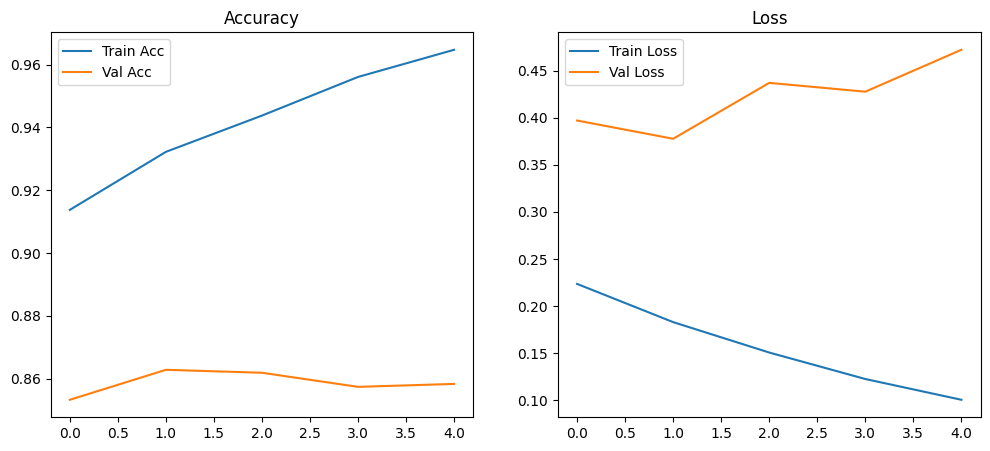

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()

y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")



In [ ]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")



Akurasi  : 0.8628
Presisi  : 0.8558
Recall   : 0.8269
F1-Score : 0.8411
AUC      : 0.9357


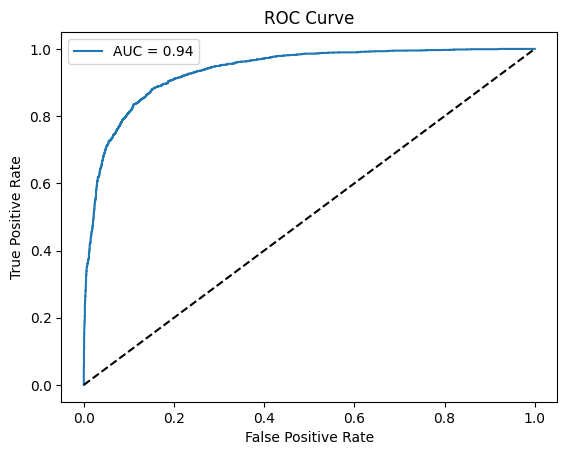

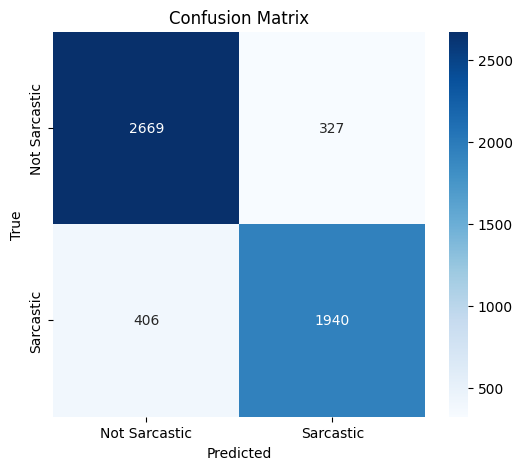

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#IMDb

In [ ]:
num_words = 30000
maxlen = 500

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Konversi ke dictionary
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=num_words,
        output_dim=hp.Choice('embedding_dim', [64, 128, 256]),
        input_length=maxlen  # pastikan maxlen diset jika ada pad_sequences
    ))

    # Simpan jumlah layer
    num_layers = hp.Int('rnn_layers', 2, 5)

    # Loop RNN layer
    for i in range(num_layers):
        model.add(SimpleRNN(
            units=hp.Int(f'rnn_units_{i}', min_value=32, max_value=128, step=32),
            return_sequences=(i < num_layers - 1)
        ))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(BatchNormalization())

    # Dense layer
    model.add(Dense(units=hp.Int('dense1', 64, 256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dense_dropout1', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer = Adam(learning_rate=lr) if optimizer_choice == 'adam' else RMSprop(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='deep_rnn_tuning'
)

early_stopping = EarlyStopping(monitor='val_loss',
                           patience=2,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2, # Kurangi LR sebesar 80%
                              patience=2,
                              min_lr=1e-6) # Batas LR minimum

tuner.search(
    x_train, y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

# Ambil model terbaik
best_model = tuner.get_best_models(num_models=1)[0]

Trial 20 Complete [00h 06m 46s]
val_accuracy: 0.5077000260353088

Best val_accuracy So Far: 0.8779000043869019
Total elapsed time: 03h 08m 06s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
history = best_model.fit(
    x_train, y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 247ms/step - accuracy: 0.9281 - loss: 0.2030 - val_accuracy: 0.8276 - val_loss: 0.7242
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 216ms/step - accuracy: 0.9413 - loss: 0.1687 - val_accuracy: 0.8376 - val_loss: 0.5209
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 214ms/step - accuracy: 0.9435 - loss: 0.1597 - val_accuracy: 0.8310 - val_loss: 0.6355
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 67s 216ms/step - accuracy: 0.9629 - loss: 0.1176 - val_accuracy: 0.8730 - val_loss: 0.4332
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 214ms/step - accuracy: 0.9721 - loss: 0.0917 - val_accuracy: 0.8238 - val_loss: 0.8215
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 215ms/step - accuracy: 0.9762 - loss: 0.0752 - val_accuracy: 0.8552 - val_loss: 0.5231


In [ ]:
# Evaluasi akhir
score = best_model.evaluate(x_test, y_test, verbose=0)
print("Akurasi Training Akhir: {:.2f}%".format(history.history['accuracy'][-1] * 100))
print("Akurasi Test Akhir: {:.2f}%".format(score[1] * 100))

Akurasi Training Akhir: 97.47%
Akurasi Test Akhir: 86.08%


In [ ]:
print("\nRingkasan model terbaik:")
best_model.summary()


Ringkasan model terbaik:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 64)        │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 500, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 500, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 500, 128)       │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,903,236 (14.89 MB)

 Trainable params: 1,951,425 (7.44 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 1,951,427 (7.44 MB)

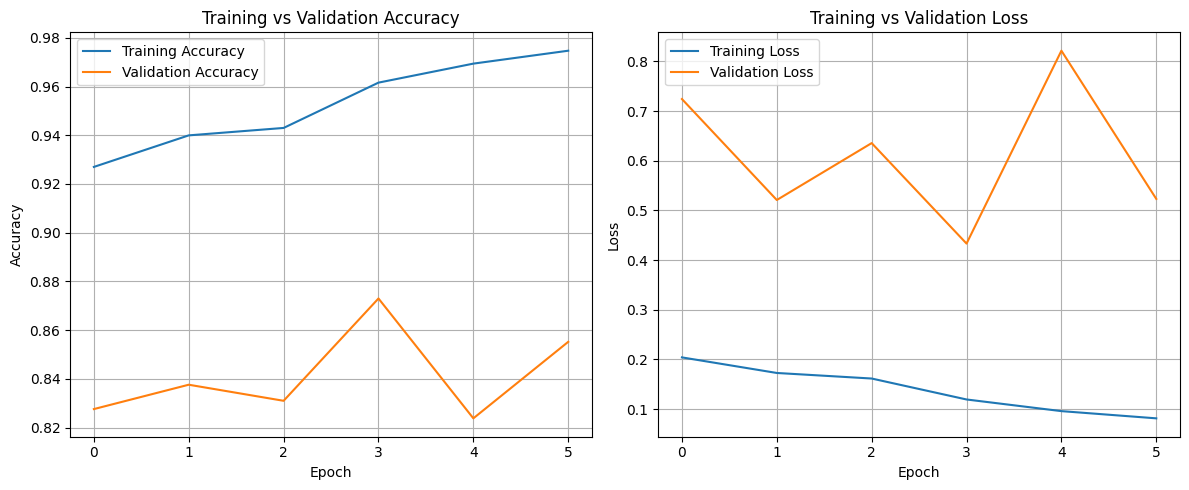

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.83      0.86     12500
    Positive       0.84      0.90      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



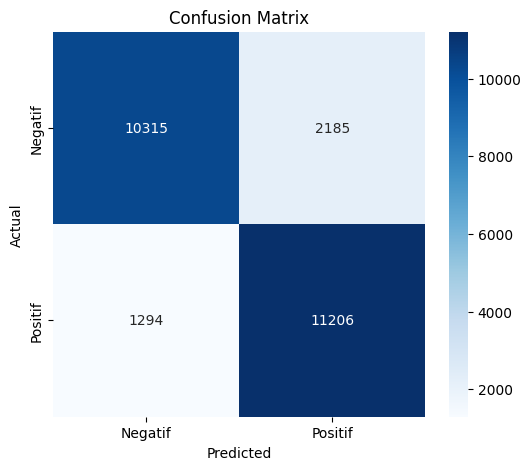

AUC Score: 0.9352


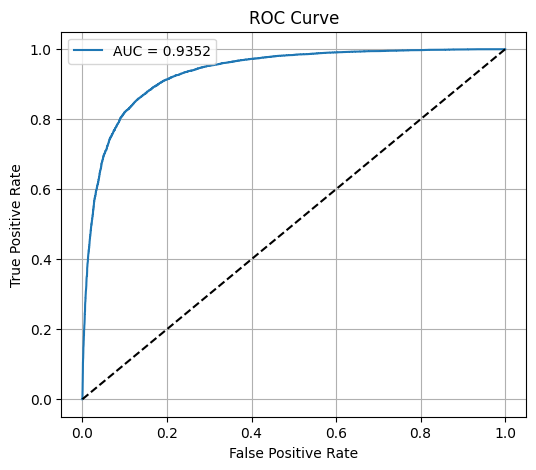

In [ ]:

# Prediksi probabilitas & kelas
y_pred_proba = best_model.predict(x_test).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

# === Evaluasi Metrik ===
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC & AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

#ReviewTokoBaju


In [ ]:
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv"
df = pd.read_csv(url)

In [ ]:
print(df)

       Unnamed: 0  Clothing ID  Age  \
0               0          767   33   
1               1         1080   34   
2               2         1077   60   
3               3         1049   50   
4               4          847   47   
...           ...          ...  ...   
23481       23481         1104   34   
23482       23482          862   48   
23483       23483         1104   31   
23484       23484         1084   28   
23485       23485         1104   52   

                                                   Title  \
0                                                    NaN   
1                                                    NaN   
2                                Some major design flaws   
3                                       My favorite buy!   
4                                       Flattering shirt   
...                                                  ...   
23481                     Great dress for many occasions   
23482                         Wish it was made of c

In [ ]:
df.isna().sum()

,0
Unnamed: 0,0
Clothing ID,0
Age,0
Title,3810
Review Text,845
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,14
Department Name,14


In [ ]:
print(df.columns)

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


In [ ]:
df = df[['Review Text', 'Rating']].copy()
df.dropna(inplace=True)

def get_sentiment(rating):
    if rating >= 4:
        return 1
    elif rating <= 2:
        return 0
    else:
        return None

df.loc[:, 'Label'] = df['Rating'].apply(get_sentiment)
df.dropna(inplace=True)
df.loc[:, 'Label'] = df['Label'].astype(int)

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df['Review Text'] = df['Review Text'].apply(clean_text)
df = df[df['Review Text'].str.strip() != '']


X = df['Review Text'].values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=40000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
vocab_size = len(tokenizer.word_index) + 1


class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights = dict(enumerate(class_weights))


In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))

    # Tuning unit RNN pertama
    model.add(SimpleRNN(units=hp.Int('units_1', min_value=32, max_value=128, step=32), return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.6, step=0.2)))

    # Tuning unit RNN kedua
    model.add(SimpleRNN(units=hp.Int('units_2', min_value=32, max_value=128, step=32), return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.6, step=0.2)))

    # Tuning unit RNN ketiga
    model.add(SimpleRNN(units=hp.Int('units_3', min_value=32, max_value=128, step=32)))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.6, step=0.2)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model dengan learning rate yang dapat dituning
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           tf.keras.metrics.AUC(name='auc')])

    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Hanya 5 iterasi
    executions_per_trial=1,  # Hanya satu percobaan untuk setiap kombinasi hyperparameter
    directory='kt_dir',
    project_name='review_sentiment_tuning',
    overwrite=True
)

# Melakukan pencarian hyperparameter
tuner.search(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test), class_weight=class_weights)

# Ambil model terbaik dan simpannya
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('best_model.h5')

# Tampilkan hasil pencarian hyperparameter terbaik
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hyperparameters.values)


Trial 5 Complete [00h 06m 11s]
val_loss: 0.2719460725784302

Best val_loss So Far: 0.23143865168094635
Total elapsed time: 00h 30m 37s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters: {'units_1': 32, 'dropout_1': 0.2, 'units_2': 32, 'dropout_2': 0.2, 'units_3': 64, 'dropout_3': 0.2, 'learning_rate': 0.00036355956120879337}


In [ ]:
best_model = tf.keras.models.load_model('best_model.h5')

# Kompilasi ulang model setelah dimuat
best_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparameters['learning_rate']),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(name='auc')]
)

# Melakukan final training (fine-tuning) pada model terbaik
history = best_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    class_weight=class_weights,
    verbose=1
)

Epoch 1/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 53s 95ms/step - accuracy: 0.9284 - auc: 0.9779 - loss: 0.1776 - precision_1: 0.9920 - recall_1: 0.9259 - val_accuracy: 0.8668 - val_auc: 0.9346 - val_loss: 0.3662 - val_precision_1: 0.9824 - val_recall_1: 0.8640
Epoch 2/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 47s 95ms/step - accuracy: 0.9519 - auc: 0.9914 - loss: 0.1121 - precision_1: 0.9961 - recall_1: 0.9492 - val_accuracy: 0.8819 - val_auc: 0.9282 - val_loss: 0.3416 - val_precision_1: 0.9724 - val_recall_1: 0.8910
Epoch 3/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 79s 90ms/step - accuracy: 0.9749 - auc: 0.9965 - loss: 0.0619 - precision_1: 0.9984 - recall_1: 0.9729 - val_accuracy: 0.9173 - val_auc: 0.9111 - val_loss: 0.3012 - val_precision_1: 0.9558 - val_recall_1: 0.9498
Epoch 4/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 83s 92ms/step - accuracy: 0.9888 - auc: 0.9990 - loss: 0.0288 - precision_1: 0.9995 - recall_1: 0.9878 - val_accuracy: 0.9130 - val_auc: 0.8952 - val_loss: 0.3354 - val_precision_1: 0.9514 - val_recall_1:

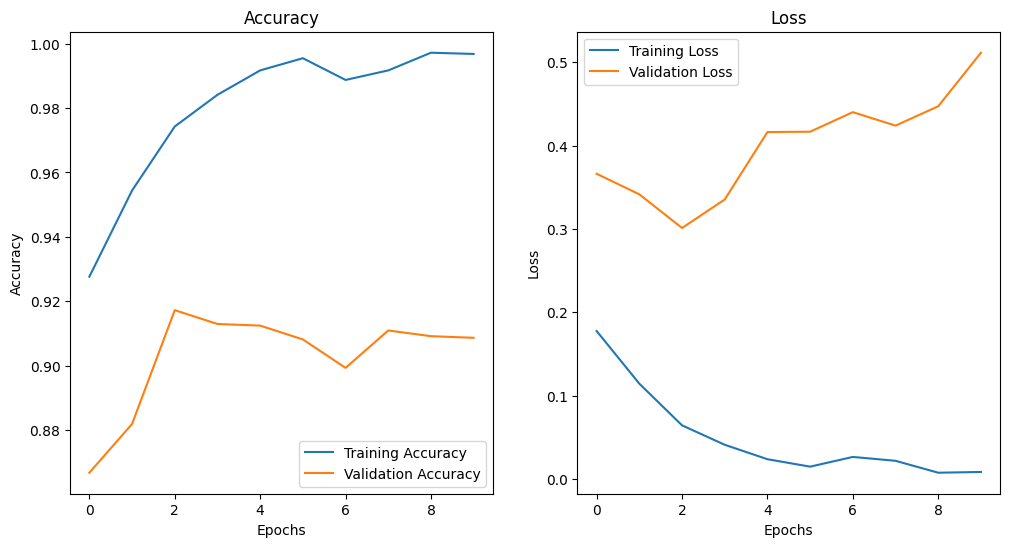

In [ ]:
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
y_pred_prob = best_model.predict(X_test_pad).flatten()  # Gunakan best_model yang sudah dilatih
y_pred = (y_pred_prob > 0.5).astype(int)  # Prediksi label (0 atau 1) berdasarkan threshold 0.5

# Menghitung metrik evaluasi
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_prob)

# Menampilkan hasil metrik
print(f"Akurasi: {acc:.4f}")
print(f"Presisi: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step
Akurasi: 0.9087
Presisi: 0.9575
Recall: 0.9378
F1-Score: 0.9475
AUC: 0.9137


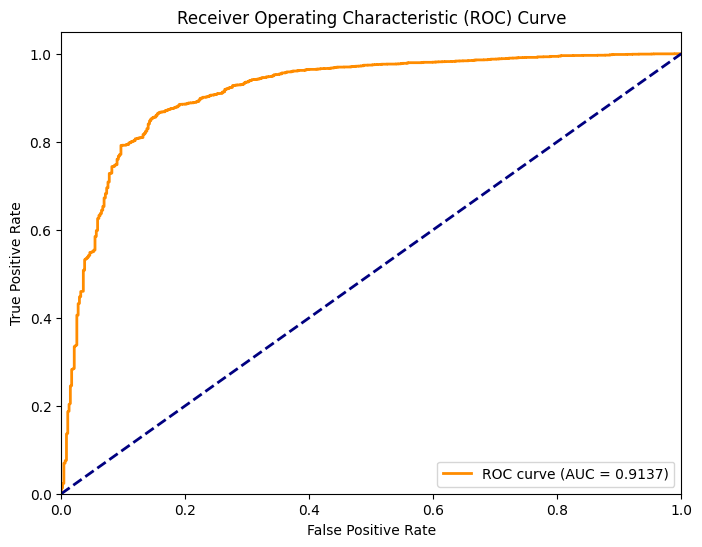

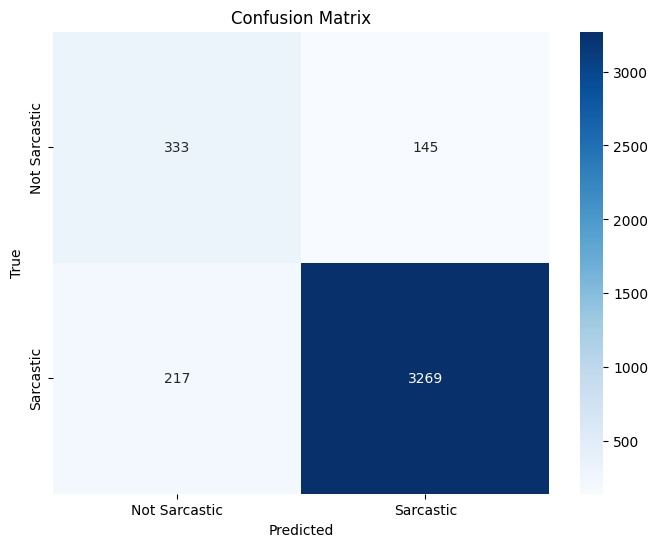

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Hitung AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Membuat confusion matrix
y_pred_class = (y_pred_prob > 0.5).astype(int)  # Mengonversi probabilitas menjadi kelas 0 atau 1
cm = confusion_matrix(y_test, y_pred_class)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Analisis Model Klasifikasi Teks pada Berbagai Dataset Menggunakan RNN di Google Colab


## 1. Penjelasan Umum Kode Google Colab


### a. Pemuatan dan Pra-pemrosesan Data
- **Pemuatan Data**: Data dimuat dari berbagai sumber (misalnya, URL file JSON, CSV, atau dataset bawaan Keras seperti IMDb).
- **Pembersihan Teks**:
    - Mengubah teks menjadi huruf kecil.
    - Menghapus karakter yang tidak diinginkan (tanda baca, angka, HTML tag) menggunakan ekspresi reguler (`re`).
    - Tokenisasi: Memecah teks menjadi token (kata-kata).
    - Penghapusan Stopwords: Menghapus kata-kata umum yang tidak memberikan banyak informasi (misalnya, "dan", "di", "atau").
- **Tokenisasi dan Padding**:
    - `Tokenizer` dari Keras digunakan untuk mengubah teks menjadi urutan (sequences) angka (integer), di mana setiap angka merepresentasikan sebuah kata dalam vocabulary.
    - `pad_sequences` digunakan untuk memastikan semua urutan memiliki panjang yang sama dengan menambahkan padding (biasanya angka 0) di awal atau akhir urutan. Ini diperlukan karena RNN mengharapkan input dengan panjang tetap.
- **Pembagian Data**: Dataset dibagi menjadi set pelatihan (train) dan set pengujian (test) menggunakan `train_test_split` dari `sklearn`.

### b. Pembangunan Model RNN
- **Arsitektur Model**: Model `Sequential` Keras digunakan untuk membangun arsitektur RNN:
    - **`Embedding` Layer**: Lapisan pertama yang mengubah urutan integer menjadi vektor padat (dense vectors) dengan dimensi tertentu. Vektor ini menangkap makna semantik dari kata-kata.
    - **`SimpleRNN` Layer(s)**: Satu atau lebih lapisan RNN sederhana yang memproses urutan data. `return_sequences=True` digunakan jika output dari lapisan RNN saat ini akan diteruskan ke lapisan RNN berikutnya.
    - **`Dropout` Layer**: Untuk mencegah overfitting dengan secara acak menonaktifkan sebagian neuron selama pelatihan.
    - **`BatchNormalization` Layer (Opsional)**: Untuk menstabilkan dan mempercepat pelatihan.
    - **`Dense` Layer**: Lapisan fully connected, biasanya satu atau lebih sebelum lapisan output.
    - **Output `Dense` Layer**: Dengan fungsi aktivasi yang sesuai (misalnya, `sigmoid` untuk klasifikasi biner atau `softmax` untuk klasifikasi multi-kelas).
- **Kompilasi Model**:
    - `optimizer`: Algoritma yang digunakan untuk mengupdate bobot model (misalnya, `Adam`, `RMSprop`).
    - `loss`: Fungsi kerugian yang mengukur seberapa baik model bekerja (misalnya, `binary_crossentropy` untuk klasifikasi biner).
    - `metrics`: Metrik yang digunakan untuk memantau kinerja model (misalnya, `accuracy`).
- **Hyperparameter Tuning (Opsional)**:
    - `keras_tuner` (misalnya, `RandomSearch` atau `Hyperband`) dapat digunakan untuk mencari kombinasi hyperparameter terbaik (seperti jumlah unit RNN, dimensi embedding, learning rate, dll.).

### c. Pelatihan Model
- Model dilatih menggunakan metode `.fit()` pada data pelatihan.
- **Callbacks**:
    - `EarlyStopping`: Untuk menghentikan pelatihan jika metrik tertentu (misalnya, `val_loss`) tidak membaik setelah beberapa epoch tertentu (patience).
    - `ReduceLROnPlateau`: Untuk mengurangi learning rate jika metrik tertentu tidak membaik.

### d. Evaluasi Model
- Model dievaluasi pada data pengujian menggunakan metode `.evaluate()`.
- **Metrik Kinerja**: Dihitung dan ditampilkan, termasuk akurasi, presisi, recall, F1-score, dan AUC.
- **Visualisasi**:
    - Kurva Akurasi dan Loss (Training vs Validation) untuk memantau overfitting.
    - Confusion Matrix untuk melihat detail kinerja klasifikasi.
    - Kurva ROC untuk mengevaluasi kemampuan diskriminatif model pada klasifikasi biner.

## 2. Analisis dan Persamaan Matematika Metrik Evaluasi

Metrik evaluasi digunakan untuk mengukur seberapa baik kinerja model klasifikasi.

### a. Istilah Dasar (untuk Klasifikasi Biner)
- **True Positive (TP)**: Jumlah sampel positif yang diprediksi dengan benar sebagai positif.
- **True Negative (TN)**: Jumlah sampel negatif yang diprediksi dengan benar sebagai negatif.
- **False Positive (FP)**: Jumlah sampel negatif yang salah diprediksi sebagai positif (Type I Error).
- **False Negative (FN)**: Jumlah sampel positif yang salah diprediksi sebagai negatif (Type II Error).

### b. Akurasi (Accuracy)
Akurasi mengukur proporsi total prediksi yang benar (baik positif maupun negatif) dari keseluruhan sampel.
$$
\text{Akurasi} = \frac{TP + TN}{TP + TN + FP + FN}
$$
Meskipun umum digunakan, akurasi bisa menyesatkan jika dataset tidak seimbang.

### c. Presisi (Precision)
Presisi mengukur proporsi sampel positif yang diprediksi dengan benar dari total sampel yang diprediksi sebagai positif. Ini menjawab pertanyaan: "Dari semua yang kita prediksi sebagai positif, berapa banyak yang benar-benar positif?"
$$
\text{Presisi} = \frac{TP}{TP + FP}
$$
Presisi tinggi menunjukkan bahwa ketika model memprediksi kelas positif, kemungkinan besar prediksi tersebut benar.

### d. Recall (Sensitivity atau True Positive Rate)
Recall mengukur proporsi sampel positif yang berhasil diidentifikasi dengan benar oleh model dari total sampel yang sebenarnya positif. Ini menjawab pertanyaan: "Dari semua yang sebenarnya positif, berapa banyak yang berhasil kita prediksi?"
$$
\text{Recall} = \frac{TP}{TP + FN}
$$
Recall tinggi menunjukkan bahwa model mampu menemukan sebagian besar sampel positif.

### e. F1-Score
F1-Score adalah rata-rata harmonik dari presisi dan recall. Ini memberikan keseimbangan antara presisi dan recall.
$$
\text{F1-Score} = 2 \times \frac{\text{Presisi} \times \text{Recall}}{\text{Presisi} + \text{Recall}}
$$
F1-Score berguna ketika kita ingin mencari keseimbangan antara presisi dan recall, terutama jika ada biaya yang berbeda untuk FP dan FN.

### f. Kurva ROC (Receiver Operating Characteristic)
Kurva ROC adalah plot grafis yang mengilustrasikan kemampuan diagnostik dari sistem klasifikasi biner saat ambang diskriminasi diubah-ubah. Kurva ini memplot True Positive Rate (Recall) terhadap False Positive Rate (FPR) pada berbagai pengaturan ambang batas.
$$
\text{False Positive Rate (FPR)} = \frac{FP}{FP + TN}
$$
Semakin dekat kurva ROC ke sudut kiri atas, semakin baik kinerja model. Garis diagonal (dari (0,0) ke (1,1)) merepresentasikan kinerja pengklasifikasi acak.

### g. AUC (Area Under the ROC Curve)
AUC adalah area di bawah kurva ROC. Nilai AUC berkisar antara 0 hingga 1.
- **AUC = 1**: Pengklasifikasi sempurna.
- **AUC = 0.5**: Pengklasifikasi tidak lebih baik dari tebakan acak.
- **AUC < 0.5**: Pengklasifikasi bekerja lebih buruk dari tebakan acak (seringkali berarti ada kesalahan dalam implementasi atau pemahaman masalah).

AUC memberikan ukuran agregat kinerja di semua ambang klasifikasi yang mungkin.

## 3. Perbandingan Hasil Antar Dataset

Berikut adalah perbandingan metrik evaluasi utama dari ketiga model pada dataset masing-masing:

| Metrik        | Deteksi Sarkasme (SimpleRNN) | IMDb (Deep RNN, Test Akhir) | Review Toko Baju (SimpleRNN) |
|---------------|------------------------------|-----------------------------|------------------------------|
| Akurasi       | 0.8628                       | 0.8608                      | 0.9087                       |
| Presisi (Pos) | 0.8558                       | 0.84                        | 0.9575                       |
| Recall (Pos)  | 0.8269                       | 0.90                        | 0.9378                       |
| F1-Score (Pos)| 0.8411                       | 0.87                        | 0.9475                       |
| AUC           | 0.9357                       | 0.9352                      | 0.9137                       |

**Analisis Perbandingan:**

- **Akurasi**: Model untuk "Review Toko Baju" mencapai akurasi tertinggi (90.87%), diikuti oleh "Deteksi Sarkasme" (86.28%) dan "IMDb" (86.08%). Ini menunjukkan bahwa model paling berhasil secara keseluruhan dalam mengklasifikasikan ulasan toko baju.
- **Presisi (Kelas Positif)**: Model "Review Toko Baju" memiliki presisi tertinggi (95.75%), yang berarti ketika model ini memprediksi sentimen positif, prediksinya sangat sering benar. Model "Deteksi Sarkasme" (85.58%) dan "IMDb" (84%) juga menunjukkan presisi yang baik.
- **Recall (Kelas Positif)**: Model "Review Toko Baju" kembali menunjukkan kinerja terbaik dengan recall 93.78%, artinya model ini mampu mengidentifikasi sebagian besar ulasan positif yang sebenarnya. Model "IMDb" (90%) juga memiliki recall yang sangat baik, sementara "Deteksi Sarkasme" (82.69%) sedikit lebih rendah.
- **F1-Score (Kelas Positif)**: F1-Score, yang menyeimbangkan presisi dan recall, tertinggi untuk "Review Toko Baju" (94.75%), diikuti oleh "IMDb" (87%) dan "Deteksi Sarkasme" (84.11%).
- **AUC**: Model "Deteksi Sarkasme" dan "IMDb" memiliki skor AUC yang hampir identik dan sangat tinggi (sekitar 0.935), menunjukkan kemampuan diskriminatif yang sangat baik antara kelas positif dan negatif di berbagai ambang batas. Model "Review Toko Baju" memiliki AUC yang sedikit lebih rendah (0.9137) tetapi masih menunjukkan kinerja yang sangat baik.

